# Modeling for Label Prediction 

In [1]:
import numpy as np
import json
import pandas as pd
from pandas.io.json import json_normalize
import xapian
import string
import sys
import time
import glob
from pandas import DataFrame
import spacy
import import_ipynb
import ast
import csv
from Features_extraction import *

importing Jupyter notebook from Features_extraction.ipynb


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight


In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

## Model 2: Label Prediction

### Reading Training File 

In [ ]:
train_set_support_refutes = "train_with_new_features.csv"
final_training_features_df = pd.read_csv((train_set_support_refutes)) 
final_training_features_df = final_training_features_df.drop(['wmd'], axis=1)

In [175]:
final_training_features_df.loc[final_training_features_df.label == 'SUPPORTS', 'response'] = '1' 
final_training_features_df.loc[final_training_features_df.label == 'REFUTES', 'response'] = '0' 

## Read Testing File

In [ ]:
test_new = ('test_with_new_features.csv')
test_set_with_evidence_text = pd.read_csv((test_new))
test_set_with_evidence_text.rename(columns={"Unnamed: 0": "claim_id"}, inplace= True)
test_set_with_evidence_text.head()

## Modeling

In [376]:
x2 = final_training_features_df[['agree_score','disagree_score','neutral_score']]
y2 = final_training_features_df['response']
y2 = y2.astype('int')

### Validation

In [379]:
x_train2, x_test2,y_train2,y_test2 = train_test_split(x2,y2,test_size =0.20,stratify=y2)

In [380]:
#SMOTE
from imblearn.over_sampling import SMOTE
import numpy as np

sm = SMOTE(random_state=12)

x_train_res2, y_train_res2 = sm.fit_sample(x_train2, y_train2)
x_test_res2, y_test_res2 = sm.fit_sample(x_test2, y_test2)

In [ ]:
Counter(y_train_res2)

#### n_estimators Tuning

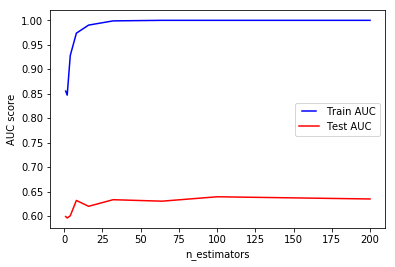

In [295]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train_res2, y_train_res2)
    train_pred = rf.predict(x_train_res2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res2, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test_res2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res2, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

#### Max Depth

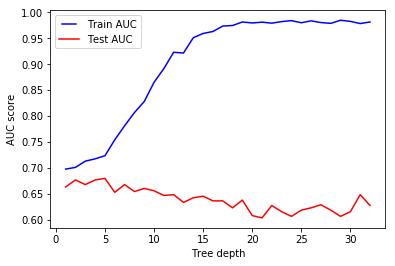

In [296]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train_res2, y_train_res2)
    train_pred = rf.predict(x_train_res2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res2, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test_res2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res2, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [382]:
from sklearn.ensemble import RandomForestClassifier

# Create thae model with 100 trees
model = RandomForestClassifier(n_estimators=50,
                              bootstrap = True,
                              max_features = 'auto', max_depth=5)
# Fit on training data
model.fit(x_train_res2, y_train_res2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [383]:
y_pred2 = model.predict(x_test_res2)

In [384]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res2, y_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6946107784431137

In [320]:
print(classification_report(y_test_res2, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       334
           1       0.68      0.72      0.70       334

    accuracy                           0.69       668
   macro avg       0.69      0.69      0.69       668
weighted avg       0.69      0.69      0.69       668



In [321]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [322]:
model_xg = XGBClassifier(max_depth=4, n_estimators=20, learning_rate=0.2, random_state=1,min_child_weight=1,gamma=0,scale_pos_weight=1)
model_xg.fit(x_train_res2, y_train_res2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [323]:
y_pred_xgb = model_xg.predict(x_test_res2)

In [324]:
print(classification_report(y_test_res2, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       334
           1       0.66      0.68      0.67       334

    accuracy                           0.67       668
   macro avg       0.67      0.67      0.67       668
weighted avg       0.67      0.67      0.67       668



In [325]:
from sklearn.ensemble import GradientBoostingClassifier

In [326]:
gbc_model = GradientBoostingClassifier(n_estimators=50, max_depth=13,learning_rate=0.2,)
gbc_model.fit(x_train_res2 , y_train_res2)
y_pred_gbc = gbc_model.predict(x_test_res2)

In [327]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res2, y_pred_gbc)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6392215568862276

In [328]:
print(classification_report(y_test_res2, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.65      0.60      0.63       334
           1       0.63      0.68      0.65       334

    accuracy                           0.64       668
   macro avg       0.64      0.64      0.64       668
weighted avg       0.64      0.64      0.64       668



### Testing

In [385]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=50,
                              bootstrap = True,
                              max_features = 'auto', max_depth=5)
# Fit on training data
model.fit(x2, y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [389]:
x_features2 = test_set_with_evidence_text[['agree_score','disagree_score','neutral_score']]

In [390]:
y_prediction2 = model.predict(x_features2)

In [ ]:
test_set_with_evidence_text["predicted_label"] = y_prediction2

In [393]:
test_set_with_evidence_text['label']= test_set_with_evidence_text['predicted_label'].apply(lambda x: 'SUPPORTS' if x == 1 else 'REFUTES')

In [395]:
test_set_with_evidence_text = test_set_with_evidence_text.drop(['text_topk','agree_score','disagree_score','neutral_score','predicted_label'], axis=1)

In [396]:
test_set_with_evidence_text = test_set_with_evidence_text.set_index('claim_id')
del test_set_with_evidence_text.index.name
test_set_with_evidence_text.head()

,evidence_topk,claim,label
11,"[['Santana_-LRB-band-RRB-', 0], ['Carlos_Santa...",Carlos Santana formed Santana in 1966.,SUPPORTS
24,"[['Dilwale_Dulhania_Le_Jayenge', 15], ['List_o...",The filming of Dilwale Dulhania Le Jayenge end...,SUPPORTS
69,"[['David_Packouz', 0]]",David Packouz was born in 1982.,REFUTES
77,"[['Nicholas_Brody', 1]]",Nicholas Brody is also called Nick.,REFUTES
83,"[['Honeymoon_-LRB-Lana_Del_Rey_album-RRB-', 0]...",Honeymoon is the third major-label record by L...,SUPPORTS


In [397]:
test_set_with_evidence_text.rename(columns={"evidence_topk": "evidence"}, inplace= True)

In [398]:
test_set_with_evidence_text.head()

,evidence,claim,label
11,"[['Santana_-LRB-band-RRB-', 0], ['Carlos_Santa...",Carlos Santana formed Santana in 1966.,SUPPORTS
24,"[['Dilwale_Dulhania_Le_Jayenge', 15], ['List_o...",The filming of Dilwale Dulhania Le Jayenge end...,SUPPORTS
69,"[['David_Packouz', 0]]",David Packouz was born in 1982.,REFUTES
77,"[['Nicholas_Brody', 1]]",Nicholas Brody is also called Nick.,REFUTES
83,"[['Honeymoon_-LRB-Lana_Del_Rey_album-RRB-', 0]...",Honeymoon is the third major-label record by L...,SUPPORTS


In [401]:
#From model 1
model1= "model_1_rf.json"
model1_predeiction_rf = pd.read_json((model1),orient='index')

In [402]:
model1_predeiction_rf.head()

,claim,evidence,label
11,Carlos Santana formed Santana in 1966.,"[[Santana_-LRB-band-RRB-, 0], [Carlos_Santana_...",SUPPORTS
24,The filming of Dilwale Dulhania Le Jayenge end...,"[[Dilwale_Dulhania_Le_Jayenge, 15], [List_of_r...",SUPPORTS
69,David Packouz was born in 1982.,"[[David_Packouz, 0]]",REFUTES
77,Nicholas Brody is also called Nick.,"[[Nicholas_Brody, 1]]",REFUTES
83,Honeymoon is the third major-label record by L...,"[[Honeymoon_-LRB-Lana_Del_Rey_album-RRB-, 0], ...",SUPPORTS


In [403]:
not_enough_data = model1_predeiction_rf[model1_predeiction_rf.label == "NOT ENOUGH INFO"] 

In [404]:
not_enough_data.count()

claim       5352
evidence    5352
label       5352
dtype: int64

In [405]:
not_enough_data.head()

,claim,evidence,label
73397,Temple of the Dog celebrated the 37th annivers...,[],NOT ENOUGH INFO
114789,A Good Day to Die Hard is part of the Library ...,[],NOT ENOUGH INFO
126871,The Icelandic Coast Guard is also known as Gae...,[],NOT ENOUGH INFO
51263,James Brolin is an orthodontist.,[],NOT ENOUGH INFO
228059,Caleb McLaughlin is a farmer.,[],NOT ENOUGH INFO


In [406]:
Model2_output =  pd.concat([test_set_with_evidence_text,not_enough_data])

In [407]:
Model2_output.head()

,claim,evidence,label
11,Carlos Santana formed Santana in 1966.,"[['Santana_-LRB-band-RRB-', 0], ['Carlos_Santa...",SUPPORTS
24,The filming of Dilwale Dulhania Le Jayenge end...,"[['Dilwale_Dulhania_Le_Jayenge', 15], ['List_o...",SUPPORTS
69,David Packouz was born in 1982.,"[['David_Packouz', 0]]",REFUTES
77,Nicholas Brody is also called Nick.,"[['Nicholas_Brody', 1]]",REFUTES
83,Honeymoon is the third major-label record by L...,"[['Honeymoon_-LRB-Lana_Del_Rey_album-RRB-', 0]...",SUPPORTS


In [408]:
# to json 
Model2_output.to_json('model2_final.json', orient='index') 

In [409]:
with open('model2_final.json') as json_file:  
    data = json.load(json_file)

In [ ]:
#to format evidence into list of list before uploading on codalab
fixing th proble of list of list
for key,val in data.items():
    lst=[]
    a = val["evidence"][1:]
    if len(a)  == 1 and  str(a[0]).isdigit():
        b = val["evidence"] 
        lst.append(b)
        val["evidence"] = lst 

In [415]:
#creating testoutput
json.dump(data, open("testoutput.json","w"),indent=0)

In [416]:
len(data)

14997